# Classification using LSTM and keywords

## Getting started

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

from src.utils.viz import *

plt.style.use('ggplot')

In [2]:
# Read & split train test
filename = './data/clean_entire_corpus.csv'
df = pd.read_csv(filename)
df_train = df[df['source'] == 'train'].copy()
df_test = df[df['source'] == 'test'].copy()

## Data preprocessing

* Cleaning keywords (fill Nan values and split keywords if needed)

In [3]:
# Handle keywords 
df_train['keyword'] = df_train['keyword'].fillna('_')
df_test['keyword'] = df_test['keyword'].fillna('_')
df_train['keyword'] = df_train['keyword'].apply(lambda x: re.sub('%20', ' ', x))
df_test['keyword'] = df_test['keyword'].apply(lambda x: re.sub('%20', ' ', x))

* Tokenize texts

In [4]:
# Encoding
def get_vocabulary(iter_sents):
    vocab = set()
    max_length = 0
    for text in iter_sents:
        tokens = text.split(' ')
        if len(tokens) > max_length:
            max_length = len(tokens)
        vocab.update(tokens)
    return vocab, max_length

_, max_length = get_vocabulary(df_train['text'])
keywords = []

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
sequences_train = tokenizer.texts_to_sequences(df_train['clean_text'])
sequences_test = tokenizer.texts_to_sequences(df_test['clean_text'])

sequences_keyword_train = tokenizer.texts_to_sequences(df_train['keyword'])
sequences_keyword_test = tokenizer.texts_to_sequences(df_test['keyword'])

* Padding texts

In [5]:
# Padding
padded_seqs_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_length,
                                                            padding='post', truncating='post')
padded_seqs_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_length,
                                                            padding='post', truncating='post')
padded_seqs_keyword_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_keyword_train, maxlen=2,
                                                                          padding='post')
padded_seqs_keyword_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_keyword_test, maxlen=2,
                                                                          padding='post')

* Convert data to tf.data.Dataset instances

In [6]:
# Data sets
X_train = (padded_seqs_train, padded_seqs_keyword_train)
X_test = (padded_seqs_test, padded_seqs_keyword_test)
y_train = df_train['target'].values
y_test = df_test['target'].values

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(100)

* Import GloVe embeddings

In [7]:
# Build an index for embeddings
embeddings_index = {}
EMBEDDINGS_PATH = '/datascience/embeddings'
EMBEDDINGS_LENGTH = 50
print('Reading lines')
with open(os.path.join(EMBEDDINGS_PATH, 'glove.6B.50d.txt'), encoding='utf-8') as f:
    lines = f.readlines()

print('Extract embeddings')
for line in lines:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Create embeddings matrix')
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDINGS_LENGTH))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Reading lines
Extract embeddings
Create embeddings matrix


## Training model

In [27]:
input_tweet = tf.keras.layers.Input(shape=(max_length, ))
input_keyword = tf.keras.layers.Input(shape=(2, ))

embeddings = tf.keras.layers.Embedding(input_dim=len(word_index)+1, input_length=max_length,
                                       output_dim=EMBEDDINGS_LENGTH, weights=[embedding_matrix], trainable=False)

# Tweets
x = embeddings(input_tweet)
x = tf.keras.layers.LSTM(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.Model(inputs=input_tweet, outputs=x)

# Keyword
y = embeddings(input_keyword)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.Model(inputs=input_keyword, outputs=y)

concat = tf.keras.layers.concatenate((x.output, y.output))

z = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(z)
model = tf.keras.Model([input_tweet, input_keyword], outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

EPOCHS = 20
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/20
69/69 [==============================] - 9s 130ms/step - loss: 0.5954 - acc: 0.6725 - val_loss: 0.4966 - val_acc: 0.7723
Epoch 2/20
69/69 [==============================] - 8s 116ms/step - loss: 0.4573 - acc: 0.7994 - val_loss: 0.4552 - val_acc: 0.7898
Epoch 3/20
69/69 [==============================] - 8s 113ms/step - loss: 0.4308 - acc: 0.8111 - val_loss: 0.4467 - val_acc: 0.7916
Epoch 4/20
69/69 [==============================] - 9s 135ms/step - loss: 0.4269 - acc: 0.8187 - val_loss: 0.4658 - val_acc: 0.7959
Epoch 5/20
69/69 [==============================] - 10s 148ms/step - loss: 0.4205 - acc: 0.8205 - val_loss: 0.4455 - val_acc: 0.7993
Epoch 6/20
69/69 [==============================] - 10s 144ms/step - loss: 0.4131 - acc: 0.8269 - val_loss: 0.4392 - val_acc: 0.7987
Epoch 7/20
69/69 [==============================] - 8s 112ms/step - loss: 0.4137 - acc: 0.8232 - val_loss: 0.4360 - val_acc: 0.8020
Epoch 8/20
69/69 [==============================] - 8s 111ms/step - loss: 

In [28]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             674350      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          91648       embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                      

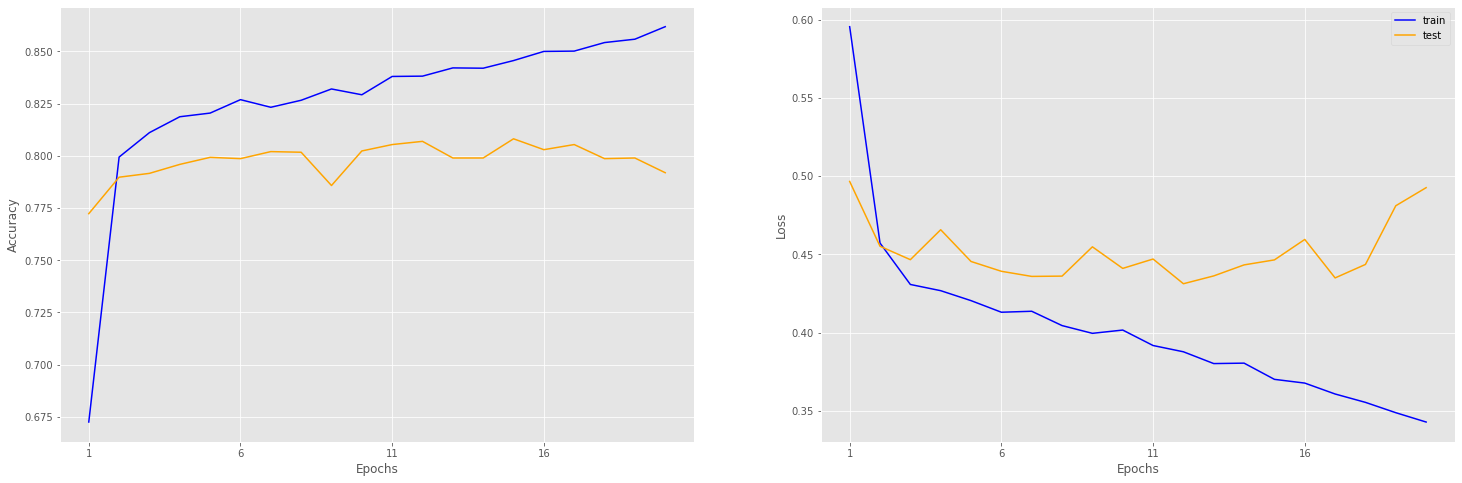

In [29]:
epochs = range(1, EPOCHS+1)
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

axs[0].plot(epochs, history.history['acc'], color='blue', label='train')
axs[0].plot(epochs, history.history['val_acc'], color='orange', label='test')
axs[0].set_xticks(range(1, EPOCHS+1, 5))
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(epochs, history.history['loss'], color='blue', label='train')
axs[1].plot(epochs, history.history['val_loss'], color='orange', label='test')
axs[1].set_xticks(range(1, EPOCHS+1, 5))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
plt.legend()

* The best score reaches 0.81 of accuracy

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14b7bc962b0>)

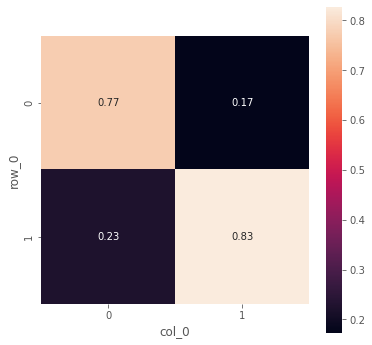

In [30]:
y_pred = model.predict(X_test).reshape(1, -1)[0]
y_pred = np.around(y_pred).astype(int)

plot_confusion_matrix(y_test, y_pred)

## Model's mistakes

In [31]:
df_test['pred'] = y_pred
model_errors = df_test[df_test['pred'] != df_test['target']]
model_errors

,id,keyword,text,target,source,clean_text,pred
6840,0,_,Just happened a terrible car crash,1,test,just happened a terrible car crash,0
6842,3,_,"there is a forest fire at spot pond, geese are...",1,test,there is a forest fire at spot pond geese are ...,0
6845,12,_,We're shaking...It's an earthquake,1,test,we are shaking it is an earthquake,0
6861,70,ablaze,Burning Man Ablaze! by Turban Diva http://t.co...,0,test,burning man ablaze by turban diva via,1
6883,142,accident,Please donate and spread the word! A training ...,0,test,please donate and spread the word a training a...,1
...,...,...,...,...,...,...,...
10084,10797,wrecked,@Nathan26_RFC thought you said Saturday night ...,0,test,thought you said saturday night there and nea...,1
10086,10804,wrecked,@yakubOObs think he deactivated because his no...,1,test,think he deactivated because his notification...,0
10087,10806,wrecked,RT CNBC '3 words from Disney CEO Bob Iger wrec...,1,test,rt cnbc words from disney ceo bob iger wrecked...,0
10096,10857,_,To conference attendees! The blue line from th...,1,test,to conference attendees the blue line from the...,0


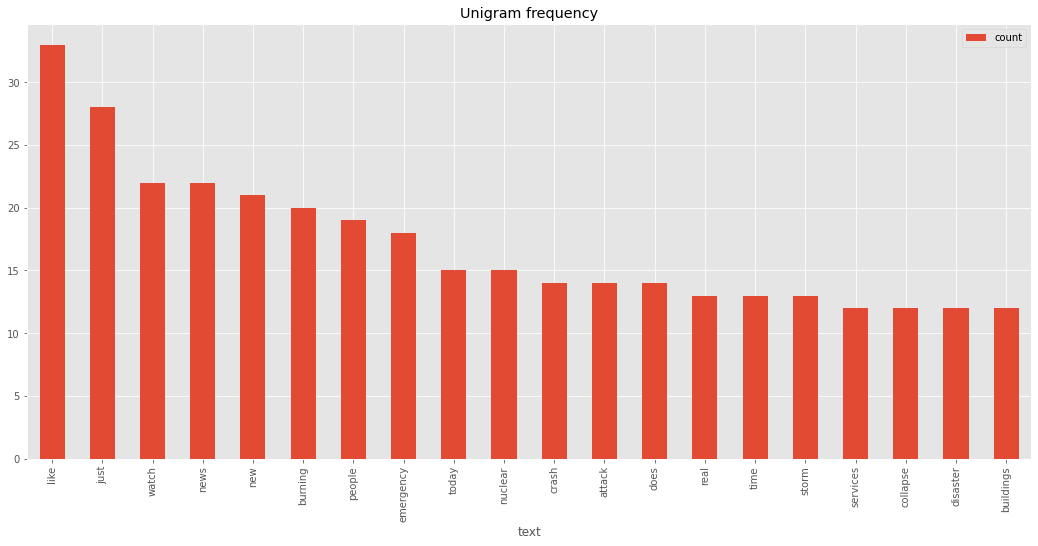

In [32]:
top_unigrams = get_top_grams(model_errors['clean_text'], 20)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_unigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Unigram frequency')

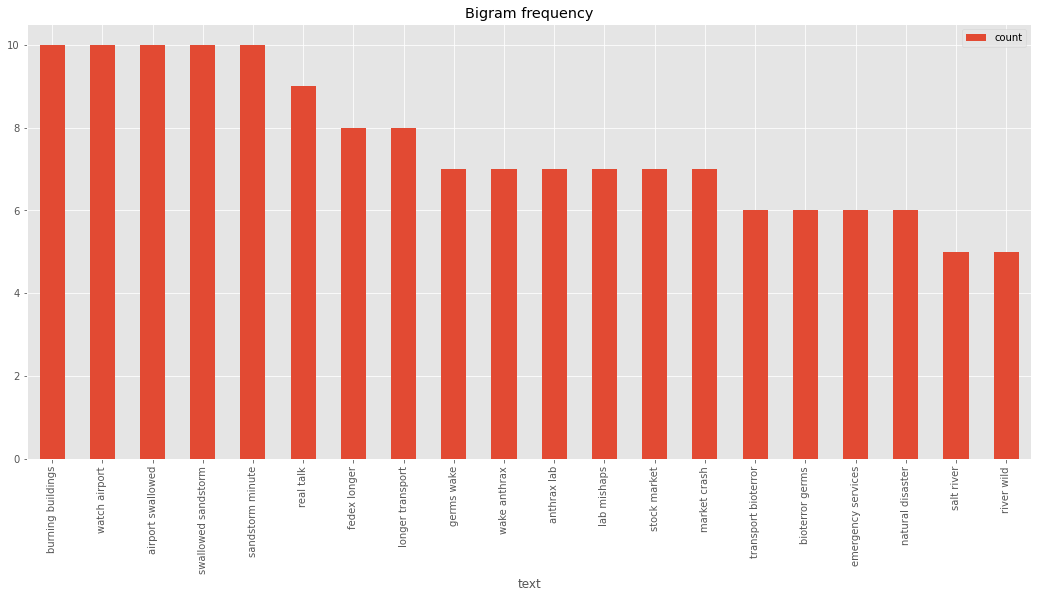

In [33]:
top_bigrams = get_top_grams(model_errors['clean_text'], 20, gram=2)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_bigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Bigram frequency')

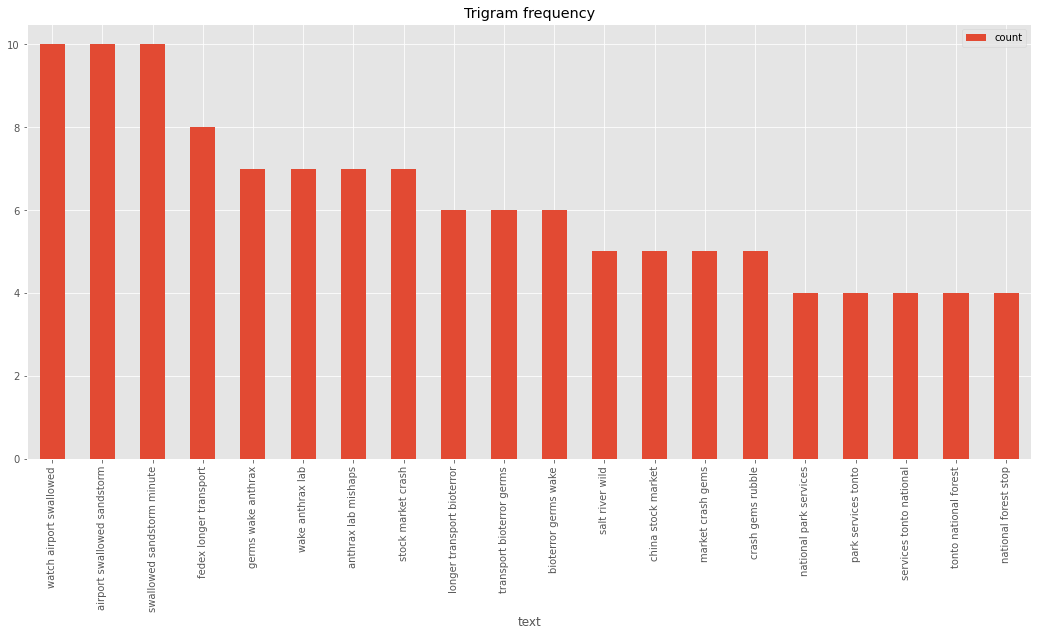

In [34]:
top_trigrams = get_top_grams(model_errors['clean_text'], 20, gram=3)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_trigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Trigram frequency')